In [2]:
!pip install timm lpips pytorch_msssim


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.0/52.0 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 3.9 MB/s eta 0:00:00


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

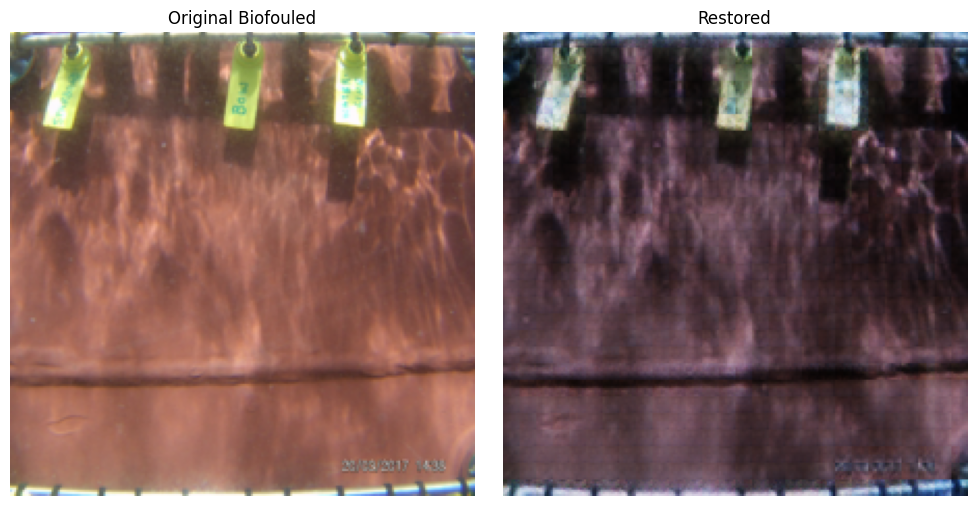

✅ Restoration complete. Images saved to: /content/drive/MyDrive/DLCV_PROJECT_DATASET/restored_images


In [3]:
# ---------------------------
# Mount and Setup
# ---------------------------
from google.colab import drive
drive.mount('/content/drive')

import os
import torch
import torch.nn as nn
import timm
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms.functional import to_pil_image
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt

# ---------------------------
# Paths and Device
# ---------------------------
base_path = '/content/drive/MyDrive/DLCV_PROJECT_DATASET'
image_folder = os.path.join(base_path, 'images')
output_restored_folder = os.path.join(base_path, 'restored_images')
os.makedirs(output_restored_folder, exist_ok=True)

# Load metadata CSV
df = pd.read_csv(os.path.join(base_path, 'metadata.csv'))
df['image_path'] = df['image.name'].apply(lambda x: os.path.join(image_folder, x))
df = df[df['image_path'].apply(os.path.exists)].reset_index(drop=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------------------------
# Transform
# ---------------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# ---------------------------
# U-Transformer Model Definition
# ---------------------------
class UTransformer(nn.Module):
    def __init__(self):
        super(UTransformer, self).__init__()
        self.encoder = timm.create_model("vit_base_patch8_224", pretrained=True, num_classes=0)
        self.up1 = nn.ConvTranspose2d(768, 384, kernel_size=2, stride=2)
        self.up2 = nn.ConvTranspose2d(384 + 384, 192, kernel_size=2, stride=2)
        self.up3 = nn.ConvTranspose2d(192 + 192, 96, kernel_size=2, stride=2)
        self.final_conv = nn.Conv2d(96, 3, kernel_size=1)

    def forward(self, x):
        x = self.encoder.forward_features(x)  # shape: [B, N, C]
        B, N, C = x.shape
        x = x[:, 1:, :]  # remove class token
        H = W = int(N**0.5)
        x = x.permute(0, 2, 1).contiguous().view(B, C, H, W)

        skip1 = x
        x = self.up1(x)
        skip2 = x
        x = self.up2(torch.cat([x, skip2], dim=1))
        skip3 = x
        x = self.up3(torch.cat([x, skip3], dim=1))
        x = self.final_conv(x)
        return torch.sigmoid(x)



# Load the saved weights
model = UTransformer().to(device)
weights_path = "/content/drive/MyDrive/DLCV_PROJECT_DATASET/u_transformer_weights.pth"
model.load_state_dict(torch.load(weights_path, map_location=device))
model.eval()  # Important for inference

# # ---------------------------
# # Load Pretrained Model
# # ---------------------------
# model = UTransformer().to(device)
# model.eval()

# # ✅ Load pretrained weights (update path if needed)
# weights_path = '/content/drive/MyDrive/DLCV_PROJECT_DATASET/u_transformer_weights.pth'
# model.load_state_dict(torch.load(weights_path, map_location=device))

# ---------------------------
# Custom Dataset (Only Biofouled Images)
# ---------------------------
class BiofouledDataset(Dataset):
    def __init__(self, df, transform=None):
        self.paths = df['image_path'].tolist()
        self.names = df['image.name'].tolist()
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img_path = self.paths[idx]
        name = self.names[idx]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, name

# Dataloader
dataset = BiofouledDataset(df, transform)
loader = DataLoader(dataset, batch_size=1, shuffle=False)

# ---------------------------
# Restoration + Visualization
# ---------------------------
def restore_and_display():
    with torch.no_grad():
        for img_tensor, name in loader:
            img_tensor = img_tensor.to(device)
            restored = model(img_tensor).cpu().squeeze(0).clamp(0, 1)

            # Save restored image
            out_pil = to_pil_image(restored)
            save_path = os.path.join(output_restored_folder, name[0])
            out_pil.save(save_path)

            # Display
            fig, axes = plt.subplots(1, 2, figsize=(10, 5))
            axes[0].imshow(img_tensor[0].permute(1, 2, 0).cpu().numpy())
            axes[0].set_title("Original Biofouled")
            axes[1].imshow(restored.permute(1, 2, 0).numpy())
            axes[1].set_title("Restored")
            for ax in axes:
                ax.axis('off')
            plt.tight_layout()
            plt.show()
            break  # Show only one image

restore_and_display()

print("✅ Restoration complete. Images saved to:", output_restored_folder)
